# Exploratory Data Analysis

## Import libraries

In [2]:
import pandas as pd

### Load data

In [3]:
df = pd.read_csv('Train.csv', sep=';')
df.head()

,name,condition,opinion,rate,rate1
0,Zegerid,GERD,"""Using it as a replacement for Nexium, since i...",10,high
1,Ethosuximide,Seizures,"""This medicine is very good at controlling me ...",10,high
2,Tri-Sprintec,Birth Control,"""I just started taking Tri Sprintec after my l...",9,high
3,Levaquin,Pneumonia,"""This medicine made me feel absolutely horribl...",5,medium
4,Methylphenidate,ADHD,"""I&#039;ve been taking Concerta since 2003. Fo...",9,high


In [4]:
len(df)

150000

In [5]:
df['opinion'].str.len().mean()

458.68765333333334

In [6]:
df['opinion'].str.len().max()

10745

In [7]:
df['opinion'].str.len().min()


3

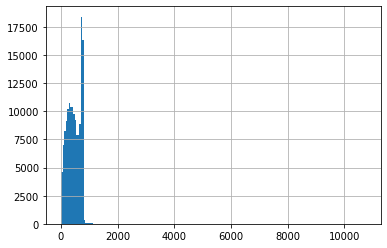

In [8]:
df['opinion'].str.len().hist(bins=200)

In [9]:
len(df[df['opinion'].str.len() < 1000])

149699

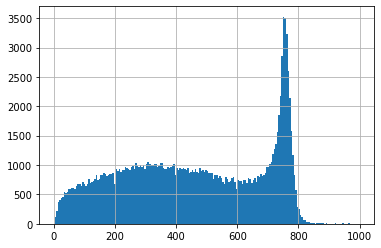

In [10]:
df[df['opinion'].str.len() < 1000]['opinion'].str.len().hist(bins=200)

In [11]:
df.groupby(by='rate').name.count()

rate
1     20156
2      6431
3      6056
4      4656
5      7463
6      5883
7      8801
8     17554
9     25527
10    47473
Name: name, dtype: int64

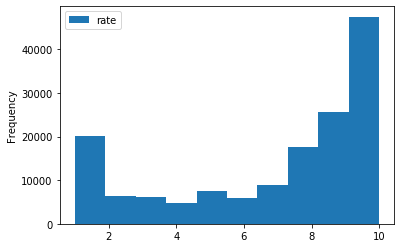

In [12]:
df.plot.hist(by='rate')


In [13]:
df['op_len'] = df['opinion'].str.len()

In [14]:
print(df.corr())
print(df[df['op_len'] < 1000 ].corr())

rate    op_len
rate    1.000000  0.021406
op_len  0.021406  1.000000
            rate    op_len
rate    1.000000  0.023162
op_len  0.023162  1.000000


In [15]:
df[df['op_len'] < 1000 ].corr().style.background_gradient(cmap='coolwarm')


,rate,op_len
rate,1.000000,0.023162
op_len,0.023162,1.000000


# Data cleaning

In [17]:
from html import unescape

Remove html escaping

In [18]:
df.update(df[df['opinion'].str.contains('&')]['opinion'].apply(unescape))
df.opinion.head()

0    "Using it as a replacement for Nexium, since i...
1    "This medicine is very good at controlling me ...
2    "I just started taking Tri Sprintec after my l...
3    "This medicine made me feel absolutely horribl...
4    "I've been taking Concerta since 2003. For me ...
Name: opinion, dtype: object

remove trailing "

In [19]:
df['opinion'] = df['opinion'].str[1:-1]
df.opinion.head()

0    Using it as a replacement for Nexium, since in...
1    This medicine is very good at controlling me s...
2    I just started taking Tri Sprintec after my la...
3    This medicine made me feel absolutely horrible...
4    I've been taking Concerta since 2003. For me i...
Name: opinion, dtype: object

In [34]:
df[df['opinion'].str.len() < 2]


,name,condition,opinion,rate,rate1,op_len
37629,Linagliptin / metformin,min),G,9,high,3
73143,Keppra,Neuralgia,I,9,high,3
95279,Ifex,Testicular Cance,-,10,high,3
99512,Ifosfamide,Testicular Cance,-,10,high,3
136845,Clonazepam,Anxiety,I,8,high,3
137422,Levetiracetam,Neuralgia,I,9,high,3


In [35]:
df = df[df['opinion'].str.len() > 2]

In [62]:
df[df['opinion'].str.contains('\n')].count()

name         16731
condition    16660
opinion      16731
rate         16731
rate1        16731
op_len       16731
dtype: int64

# N-Grams & logistic regression

In [63]:
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


In [64]:
train, test = train_test_split(df, test_size=0.2)

In [65]:
print(train.shape, test.shape)

(119992, 6) (29998, 6)


In [79]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_train_tfidf = tfidf_vect.fit_transform(train['opinion'])
len(tfidf_vect.vocabulary_)


10000

In [87]:
indices = np.argsort(tfidf_vect.idf_)[::-1]
features = tfidf_vect.get_feature_names()
[features[i] for i in indices[:100]]

['vimpat',
 'subutex',
 'psa',
 'champix',
 'advair',
 'atripla',
 'reglan',
 'relpax',
 'trintellix',
 'requip',
 'shingles',
 'invokana',
 'lantus',
 'allegra',
 'bydureon',
 'focalin',
 'bystolic',
 'fungus',
 'blister',
 'copaxone',
 'my viral',
 'milligrams',
 'gildess',
 'infusions',
 'fasting',
 'mobic',
 'differin',
 'paraguard',
 'gatorade',
 'minocycline',
 'duac',
 'atrial',
 'the patches',
 'placement',
 'retin',
 'tegretol',
 'your face',
 'voltaren',
 'blackheads',
 'levora',
 'in her',
 'egg',
 'belsomra',
 'drip',
 'my asthma',
 'aura',
 'otezla',
 'lamotrigine',
 'rebound',
 'name brand',
 'amitiza',
 'risperdal',
 'bar',
 'lupus',
 'units',
 'progesterone',
 'dairy',
 'wrist',
 'cortisone',
 'lupron',
 'the restroom',
 'ejaculation',
 'my shoulder',
 'benzo',
 'stones',
 'shirts',
 'copd',
 'beer',
 'epilepsy',
 'lorazepam',
 'cr',
 'the tablets',
 'copper',
 '15 days',
 'the rash',
 'flomax',
 'odor',
 'the muscle',
 'nexium',
 'drysol',
 'spring',
 'the name',
 'wea

In [88]:
lr = LogisticRegression(solver='saga',        
                        multi_class='multinomial',
                        penalty='l1',
                        random_state=42)
lr.fit(X_train_tfidf, train['rate'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l1',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [90]:
X_test_tfidf = tfidf_vect.transform(test['opinion'])

In [91]:
predicted = lr.predict(X_test_tfidf)

accuracy = np.sum(predicted == test['rate']) / predicted.shape[0]
print(accuracy)

0.45889725981732116


In [92]:
error = np.sum(np.abs(predicted - test['rate'])) / predicted.shape[0]
print(error)

1.5042336155743716


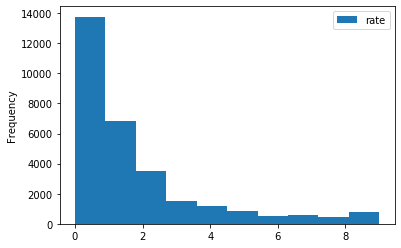

In [93]:
pd.DataFrame(data=np.abs(predicted - test['rate'])).plot.hist()

Get drug and disease names for stop words

In [106]:
drug_names = df['name'].str.lower().unique()
drug_names

array(['zegerid', 'ethosuximide', 'tri-sprintec', ..., 'tinzaparin',
       'lactic acid', 'vanspar'], dtype=object)

In [119]:
disease_names = df['condition'].str.lower().dropna()

disease_names = disease_names[~disease_names.str.contains('</span>')].unique()

In [121]:
stop_words = list(disease_names) + list(drug_names)
stop_words

arcinoma',
 'influenza',
 'gastroparesis',
 'min / sitagliptin)',
 'psychosis',
 'gingivitis',
 'hypersomnia',
 'herpes simplex',
 'postoperative pain',
 'copd, acute',
 'dry eye disease',
 'cough and nasal congestion',
 "parkinson's disease",
 'chlamydia infection',
 'kidney infections',
 'sedation',
 'peripheral neuropathy',
 'atopic dermatitis',
 'angina',
 'menorrhagia',
 'rhinitis',
 'high cholesterol, familial heterozygous',
 'atigue',
 'agitated state',
 'motion sickness',
 'hypoestrogenism',
 "tourette's syndrome",
 'back pain',
 'hiccups',
 'iron deficiency anemia',
 'organ transplant, rejection prophylaxis',
 'constipation, drug induced',
 'premenstrual dysphoric disorde',
 'neuritis',
 "crohn's disease, acute",
 'juvenile idiopathic arthritis',
 'vertig',
 'keratosis',
 'nasal congestion',
 'anesthesia',
 'sciatica',
 'pulmonary embolism',
 'conjunctivitis, bacterial',
 'light anesthesia',
 'ovarian cance',
 'gas',
 'cervical dystonia',
 'gout, acute',
 'acute promyelocytic 

In [132]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), max_features=15000, sublinear_tf=True)
X_train_tfidf = tfidf_vect.fit_transform(train['opinion'])
len(tfidf_vect.vocabulary_)


15000

In [134]:
lr = LogisticRegression(solver='saga',        
                        multi_class='multinomial',
                        penalty='l1',
                        random_state=42)
lr.fit(X_train_tfidf, train['rate'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l1',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [135]:
X_test_tfidf = tfidf_vect.transform(test['opinion'])

In [136]:
predicted = lr.predict(X_test_tfidf)

accuracy = np.sum(predicted == test['rate']) / predicted.shape[0]
print(accuracy)

0.46136409093939595


In [137]:
error = np.sum(np.abs(predicted - test['rate'])) / predicted.shape[0]
print(error)

1.4857323821588106


In [147]:
indices = np.argsort(tfidf_vect.idf_)[::-1]
features = tfidf_vect.get_feature_names()
[(features[i], tfidf_vect.idf_[i]) for i in indices[13000:13100]]

[('been in', 5.962977980262188),
 ('needed to', 5.961786794892036),
 ('for at', 5.960597026756447),
 ('feels like', 5.960597026756447),
 ('large', 5.960597026756447),
 ('together', 5.959408672487068),
 ('take my', 5.958221728727539),
 ('200', 5.957036192133438),
 ('moods', 5.957036192133438),
 ('had period', 5.957036192133438),
 ('quality of', 5.957036192133438),
 ('greatly', 5.955852059372221),
 ('since ve', 5.955852059372221),
 ('started at', 5.955852059372221),
 ('throughout the', 5.955852059372221),
 ('down and', 5.954669327123171),
 ('helps with', 5.954669327123171),
 ('now that', 5.954669327123171),
 ('arms', 5.954669327123171),
 ('hope it', 5.95348799207734),
 ('to worry', 5.95348799207734),
 ('option', 5.95348799207734),
 ('my legs', 5.95348799207734),
 ('months my', 5.952308050937492),
 ('psychiatrist', 5.952308050937492),
 ('bleeding and', 5.952308050937492),
 ('careful', 5.952308050937492),
 ('dose and', 5.951129500418047),
 ('severe and', 5.9499523372450325),
 ('using for',

Examples of BIG mistakes

In [170]:
def f(x):
    if x > 7:
        return 'high'
    if x > 3:
        return 'medium'
    return 'low'

accuracy1 = np.sum(np.array([f(p) for p in predicted]) == test['rate1']) / predicted.shape[0]
print(accuracy1)
for p, r , r2 in zip(predicted, test['opinion'], test['rate']):
    if abs(p-r2) > 6:
        print('opinion=', r, 'predicted=', p, 'rate=',r2)

 on Amlodipine, which lowered my blood pressure to 134/74 in 2 weeks, and NO side effects! The pounding in my chest GONE! A true wonder for me! predicted= 1 rate= 10
opinion= Couple months ago, I was on the nuvaring. Biggest mistake of my life. It has changed what I loved, knew and liked. I had the nuva ring in for 2 weeks, only 2 weeks. I had a major stroke on Jan.31 2015 caused by this product. It killed 25% of my brain (back left portion). Had to relearn everything; to using a fork, writing, telling the time, etc. There's no side effects or warning this was going to happen, I just fell over and was in a coma for 3days. Now, I'm 18 fresh out of high school, I had a job, was going to school and just got my licence. But can't do that anymore.
In other words, I strongly do not prompt this product. It should be taken off the market. Its deadly. 
I hope you are all safe, strong, women...and stay that way.
Be safe<3 predicted= 10 rate= 1
opinion= I had such a severe reaction to my hayfever